In [225]:
import pandas as pd
import numpy as np
from salmon.triplets.offline import OfflineEmbedding
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle

In [226]:
trips_df = pd.read_csv('../../results/reptile_tool/davinci_triplet_feature_list_pruned.csv', index_col=0).reset_index()

In [227]:
heads = []
winners = []
losers =[]
for i, row in trips_df.iterrows():
    heads.append(row['Anchor'])
    winners.append(row['gpt_choice'])
    if row['Concept1']==row['gpt_choice']:
        losers.append(row['Concept2'])
    else:
        losers.append(row['Concept1'])
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})

In [229]:
concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(30)))

In [231]:
concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(30)))
int_to_concept_dict = dict(zip(np.arange(30),np.unique(trips_df)))
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

In [232]:
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

In [233]:
concept_to_int_dict.keys()

dict_keys(['Alligator', 'Anvil', 'Axe', 'Blindworm', 'Boa python', 'Caiman', 'Chameleon', 'Chisel', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko', 'Grinding disk', 'Hammer', 'Knife', 'Lawn Mower', 'Lizard', 'Nail', 'Oil can', 'Paint brush', 'Salamander', 'Saw', 'Screwdriver', 'Shovel', 'Snake', 'Spanner', 'Toad', 'Tortoise', 'Turtle', 'Vacuum'])

In [197]:
n = len(np.unique(trips_df))
d=3

In [234]:
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)

In [235]:
fit_online=True

In [236]:
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/reptile_tool/reptile_tool_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.5460751056671143
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.556', 'train_data': 1171, 'max_epochs': 8000, '_epochs': '1.093', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.696', 'train_data': 1171, 'max_epochs': 8000, '_epochs': '55.747', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.687', 'score_test': '0.700', 'train_data': 1171, 'max_epochs': 8000, '_epochs': '110.401', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.676', 'score_test': '0.706', 'train_data': 1171, 'max_epochs': 8000, '_epochs': '165.056', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.665', 'score_test': '0.706', 'train_data': 1171, 'max_epochs': 8000, '_epochs': '219.710', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.653', 'score_test': '0.706', 'train_data

In [237]:
embeddings_df = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(30,1),model.embedding_)))
embeddings_df.columns = ['concept','embed_1','embed_2','embed_3']

In [238]:
embeddings_df['category'] = embeddings_df.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df = embeddings_df.sort_values(by = ['category','concept']).reset_index(drop=True)

In [261]:
embeddings_df.to_csv('../../data/reptile_tool/reptile_tool_embedding_df.csv')

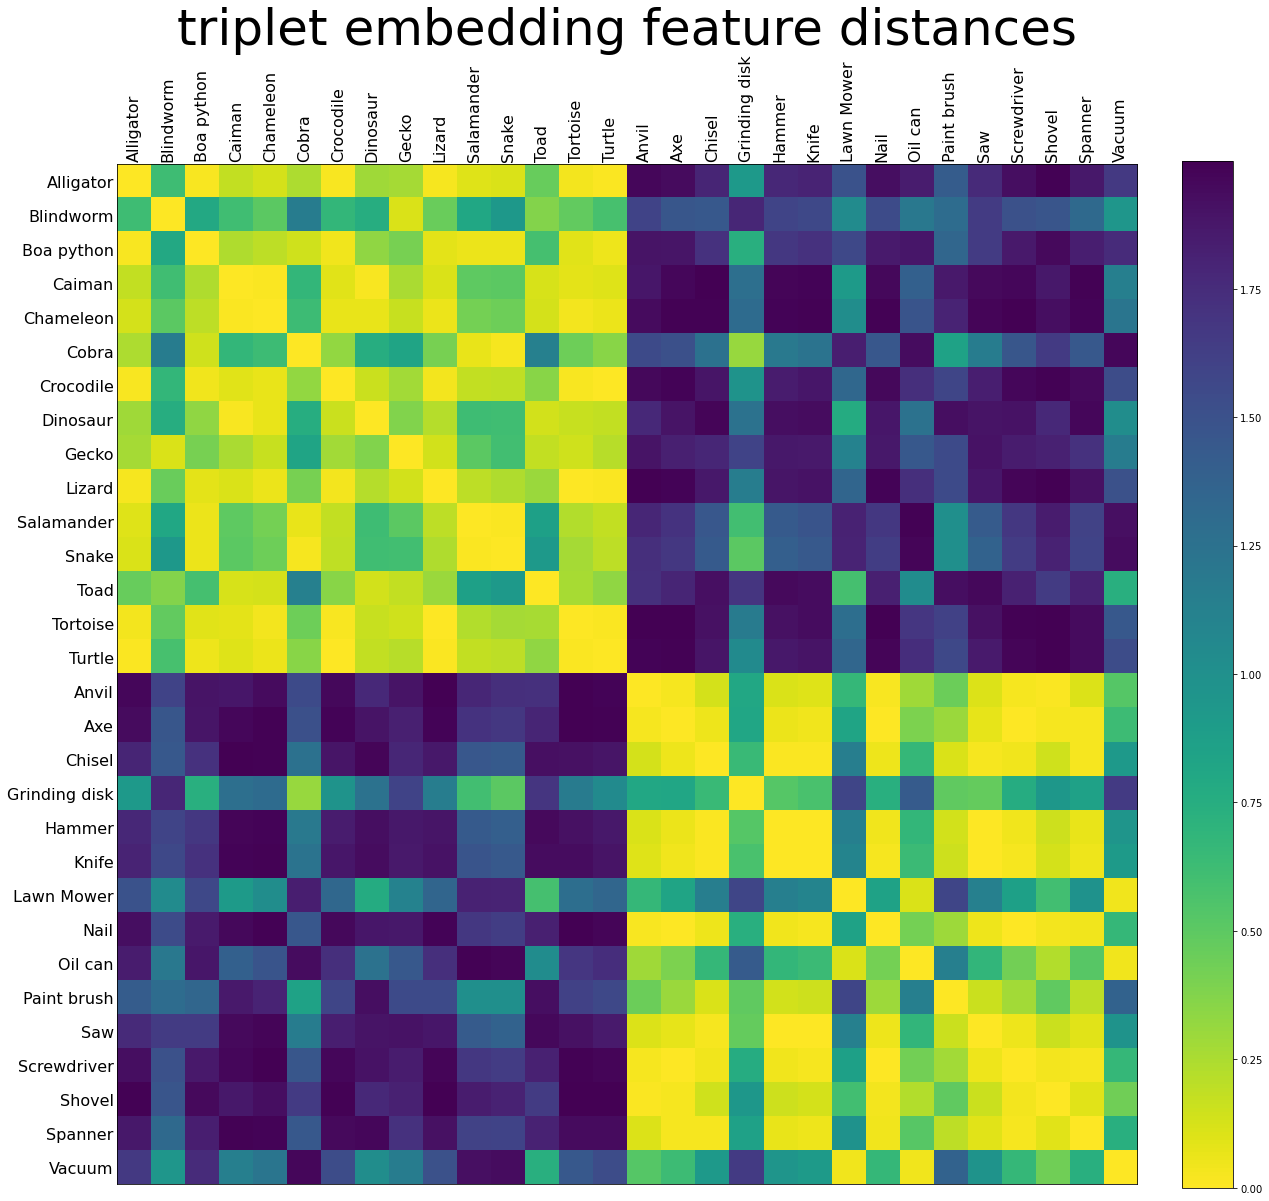

In [291]:
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df.shape[0]),embeddings_df.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df.shape[0]),embeddings_df.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()

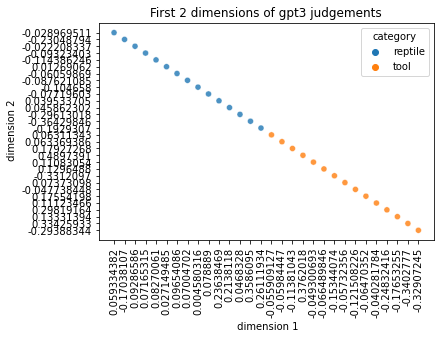

In [316]:
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of gpt3 judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
plt.xticks(rotation=90)
plt.show()


In [309]:
embeddings_df['embed_1'].min()

'-0.040281784'

In [241]:
items = np.unique(trips_df)
items = np.array([int_to_concept_dict[x] for x in items])

In [251]:
salmon_exp_df = trips [['Anchor','Concept1','Concept2']]

In [242]:
item_ind_dict = dict(zip(items,range(items.shape[0])))

In [243]:
def make_inds(x):
    y = [item_ind_dict[i] for i in x.values]
    return(y)

In [252]:
salmon_exp_df = salmon_exp_df.apply(make_inds)

In [254]:
salmon_exp_df.to_csv('../../data/reptile_tool/salmon_exp_triplets.csv',index=None)

In [255]:
for i,row in salmon_exp_df.iterrows():
    print(f"- [{row[0]},{row[1]},{row[2]}]")

- [21,0,5]
- [9,0,22]
- [20,0,17]
- [6,0,18]
- [21,0,26]
- [7,0,15]
- [9,0,12]
- [20,0,3]
- [2,0,18]
- [18,0,19]
- [1,0,4]
- [24,0,7]
- [28,0,23]
- [18,0,27]
- [8,0,26]
- [14,0,19]
- [28,0,21]
- [18,0,12]
- [29,0,20]
- [24,0,14]
- [16,0,1]
- [16,0,9]
- [2,0,11]
- [16,0,17]
- [7,0,28]
- [4,0,10]
- [9,0,5]
- [16,0,2]
- [17,0,24]
- [21,0,25]
- [25,0,4]
- [4,0,11]
- [3,0,10]
- [1,0,23]
- [5,0,25]
- [5,0,14]
- [27,0,5]
- [11,0,26]
- [6,0,11]
- [10,0,2]
- [17,0,4]
- [12,0,24]
- [19,0,26]
- [9,0,1]
- [19,0,3]
- [8,0,16]
- [10,0,5]
- [8,0,3]
- [23,0,14]
- [10,0,1]
- [14,0,25]
- [6,0,29]
- [27,0,20]
- [8,0,17]
- [2,0,3]
- [15,0,27]
- [11,0,23]
- [24,0,1]
- [21,0,18]
- [9,0,21]
- [3,0,19]
- [5,0,29]
- [19,0,25]
- [2,0,10]
- [12,0,26]
- [11,0,5]
- [12,0,27]
- [20,0,15]
- [3,0,12]
- [4,0,6]
- [9,0,16]
- [4,0,7]
- [17,0,16]
- [23,0,20]
- [26,0,22]
- [4,0,23]
- [13,1,16]
- [15,1,14]
- [7,1,18]
- [18,1,6]
- [14,1,11]
- [14,1,19]
- [6,1,29]
- [17,1,7]
- [21,1,24]
- [24,1,15]
- [14,1,23]
- [17,1,10]
- 

In [257]:
for i in item_ind_dict.keys():
    print(f'"{i}",')

"Alligator",
"Anvil",
"Axe",
"Blindworm",
"Boa python",
"Caiman",
"Chameleon",
"Chisel",
"Cobra",
"Crocodile",
"Dinosaur",
"Gecko",
"Grinding disk",
"Hammer",
"Knife",
"Lawn Mower",
"Lizard",
"Nail",
"Oil can",
"Paint brush",
"Salamander",
"Saw",
"Screwdriver",
"Shovel",
"Snake",
"Spanner",
"Toad",
"Tortoise",
"Turtle",
"Vacuum",


In [25]:
trips2.shape

(234, 3)

In [263]:
responses = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets.csv')

In [264]:
responses

,head,left,right,winner,sampler,score,puid,response_time,network_latency,time_received,...,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time,puid_num_responses,num_responses
0,2,15,4,15,Random,-9999.0,9ebb7e54858df647,4.610,0.366,1.657608e+09,...,Lawn Mower,Boa python,Axe,Lawn Mower,Boa python,489.878654,2022-07-12T06:47:06.571000,1.657608e+09,1,1
1,13,2,11,2,Random,-9999.0,9ebb7e54858df647,2.113,0.144,1.657608e+09,...,Axe,Gecko,Hammer,Axe,Gecko,492.122653,2022-07-12T06:47:08.815000,1.657608e+09,2,2
2,6,0,18,0,Validation,1.0,9ebb7e54858df647,1.960,0.141,1.657608e+09,...,Alligator,Oil can,Chameleon,Alligator,Oil can,494.270653,2022-07-12T06:47:10.963000,1.657608e+09,3,3
3,11,24,18,24,Random,-9999.0,9ebb7e54858df647,2.146,0.165,1.657608e+09,...,Snake,Oil can,Gecko,Snake,Oil can,496.533653,2022-07-12T06:47:13.226000,1.657608e+09,4,4
4,28,9,19,9,Random,-9999.0,9ebb7e54858df647,2.122,0.136,1.657608e+09,...,Crocodile,Paint brush,Turtle,Crocodile,Paint brush,498.791653,2022-07-12T06:47:15.484000,1.657608e+09,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,7,0,15,15,Validation,5.0,03c394037a79d7fe,2.097,0.195,1.657614e+09,...,Alligator,Lawn Mower,Chisel,Lawn Mower,Alligator,6480.704654,2022-07-12T08:26:57.397000,1.657608e+09,196,2196
2196,24,0,7,0,Validation,6.0,03c394037a79d7fe,1.487,0.204,1.657614e+09,...,Alligator,Chisel,Snake,Alligator,Chisel,6482.289654,2022-07-12T08:26:58.982000,1.657608e+09,197,2197
2197,14,10,15,15,Random,-9999.0,03c394037a79d7fe,1.428,0.094,1.657614e+09,...,Dinosaur,Lawn Mower,Knife,Lawn Mower,Dinosaur,6483.810653,2022-07-12T08:27:00.503000,1.657608e+09,198,2198
2198,23,27,15,15,Random,-9999.0,03c394037a79d7fe,1.536,0.094,1.657614e+09,...,Tortoise,Lawn Mower,Shovel,Lawn Mower,Tortoise,6485.442653,2022-07-12T08:27:02.135000,1.657608e+09,199,2199


In [265]:
a = responses.groupby('puid')['puid_num_responses'].max()==200
a = a[a==True].index

In [267]:
responses_clean = responses[responses.puid.isin(a)].reset_index(drop=True)

In [268]:
responses_clean.to_csv('../../data/reptile_tool/reptile_tool_human_triplets_clean.csv')

In [269]:
responses_clean

,head,left,right,winner,sampler,score,puid,response_time,network_latency,time_received,...,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time,puid_num_responses,num_responses
0,2,15,4,15,Random,-9999.0,9ebb7e54858df647,4.610,0.366,1.657608e+09,...,Lawn Mower,Boa python,Axe,Lawn Mower,Boa python,489.878654,2022-07-12T06:47:06.571000,1.657608e+09,1,1
1,13,2,11,2,Random,-9999.0,9ebb7e54858df647,2.113,0.144,1.657608e+09,...,Axe,Gecko,Hammer,Axe,Gecko,492.122653,2022-07-12T06:47:08.815000,1.657608e+09,2,2
2,6,0,18,0,Validation,1.0,9ebb7e54858df647,1.960,0.141,1.657608e+09,...,Alligator,Oil can,Chameleon,Alligator,Oil can,494.270653,2022-07-12T06:47:10.963000,1.657608e+09,3,3
3,11,24,18,24,Random,-9999.0,9ebb7e54858df647,2.146,0.165,1.657608e+09,...,Snake,Oil can,Gecko,Snake,Oil can,496.533653,2022-07-12T06:47:13.226000,1.657608e+09,4,4
4,28,9,19,9,Random,-9999.0,9ebb7e54858df647,2.122,0.136,1.657608e+09,...,Crocodile,Paint brush,Turtle,Crocodile,Paint brush,498.791653,2022-07-12T06:47:15.484000,1.657608e+09,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,7,0,15,15,Validation,5.0,03c394037a79d7fe,2.097,0.195,1.657614e+09,...,Alligator,Lawn Mower,Chisel,Lawn Mower,Alligator,6480.704654,2022-07-12T08:26:57.397000,1.657608e+09,196,2196
1796,24,0,7,0,Validation,6.0,03c394037a79d7fe,1.487,0.204,1.657614e+09,...,Alligator,Chisel,Snake,Alligator,Chisel,6482.289654,2022-07-12T08:26:58.982000,1.657608e+09,197,2197
1797,14,10,15,15,Random,-9999.0,03c394037a79d7fe,1.428,0.094,1.657614e+09,...,Dinosaur,Lawn Mower,Knife,Lawn Mower,Dinosaur,6483.810653,2022-07-12T08:27:00.503000,1.657608e+09,198,2198
1798,23,27,15,15,Random,-9999.0,03c394037a79d7fe,1.536,0.094,1.657614e+09,...,Tortoise,Lawn Mower,Shovel,Lawn Mower,Tortoise,6485.442653,2022-07-12T08:27:02.135000,1.657608e+09,199,2199


In [270]:
X_train=responses_clean[responses_clean.sampler=='Random']
X_test=responses_clean[responses_clean.sampler=='Validation']

In [272]:
X_train = X_train[['head','winner','loser']].to_numpy()
X_test = X_test[['head','winner','loser']].to_numpy()

In [ ]:
fit_online==True

In [274]:
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/reptile_tool/reptile_tool_human_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.47204968333244324
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.472', 'train_data': 1639, 'max_epochs': 8000, '_epochs': '1.015', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.692', 'score_test': '0.739', 'train_data': 1639, 'max_epochs': 8000, '_epochs': '51.778', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.656', 'score_test': '0.764', 'train_data': 1639, 'max_epochs': 8000, '_epochs': '102.541', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.603', 'score_test': '0.739', 'train_data': 1639, 'max_epochs': 8000, '_epochs': '153.303', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.557', 'score_test': '0.739', 'train_data': 1639, 'max_epochs': 8000, '_epochs': '204.066', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.523', 'score_test': '0.739', 'train_dat

In [275]:
human_embeddings_df = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(30,1),model.embedding_)))
human_embeddings_df.columns = ['concept','embed_1','embed_2','embed_3']

In [276]:
human_embeddings_df['category'] = human_embeddings_df.apply(lambda x: concept_to_category[x['concept']],axis=1)
human_embeddings_df = human_embeddings_df.sort_values(by = ['category','concept']).reset_index(drop=True)

In [320]:
human_embeddings_df.to_csv('../../data/reptile_tool/human_reptile_tool_embedding_df.csv')

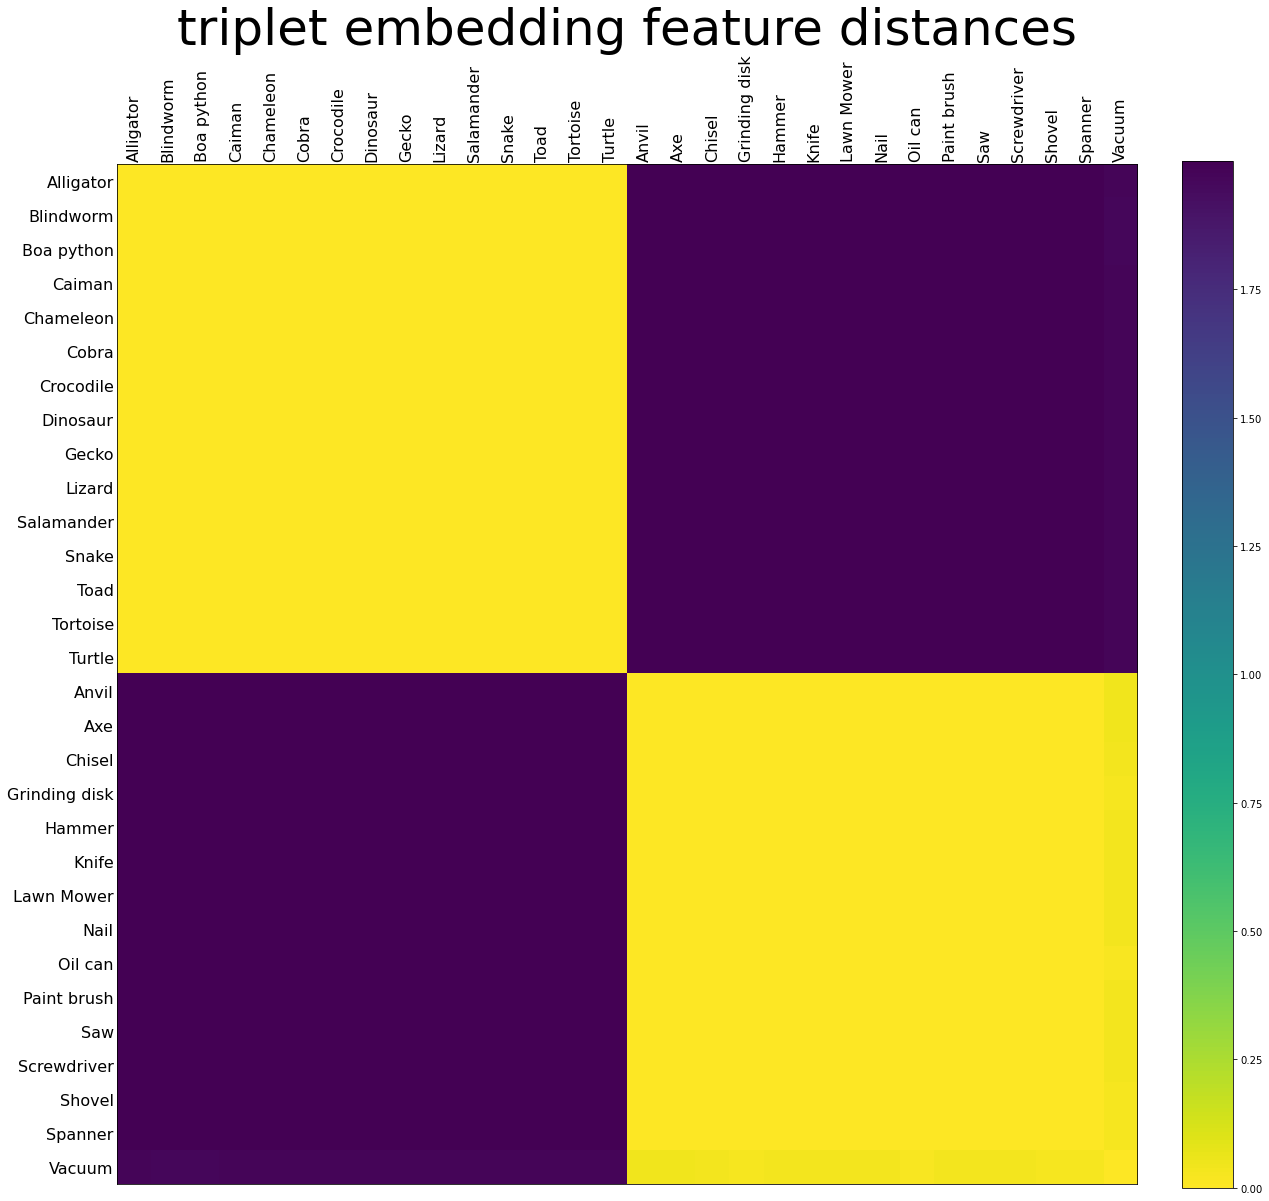

In [298]:
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(human_embeddings_df[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df.shape[0]),embeddings_df.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df.shape[0]),embeddings_df.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()

Text(0, 0.5, ' dimension 2')

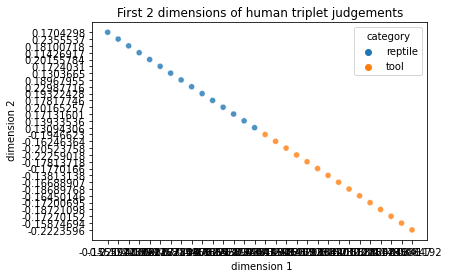

In [284]:
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=human_embeddings_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')